# **Определение перспективного тарифа для телеком-компании** 

# Оглавление
1. [Цель проекта](#purpose)
2. [Исходные данные](#data)
3. [Предобработка данных](#preprocessing)
    * [Объединение таблиц users и tariffs](#merging)
    * [Округление длительности звонков и интернет-трафика по условиям тарифа, группировка данных по месяцам](#round)
    * [Сведение всех данных в единый датасет](#merging_2)
    * [Удаление пустых значений и изменение типа данных столбцов](#dropna)
4. [Подготовка расчётных данных](#counting)
    * [Расчёт ежемесячной выручки по пользователям](#month_revenue)
    * [Промежуточные выводы](#concl)
5. [Анализ данных](#analysis)
    * [Доли тарифов в выборке](#pie)
    * [Динамика соотношения тарифов по месяцам](#part_month)
    * [Анализ характеристик распределения данных](#describe)
    * [Гистограммы распределений](#hist)
6. [Проверка гипотез (анализ выручки)](#revenue)
    * [Анализ характеристик распределения выручки](#revenue_describe)
    * [Проверка гипотезы о равенстве выручки по тарифам](#hyp1)
    * [Проверка гипотезы равенства выручки в Москве и регионах](#hyp2)
7. [Выводы](#end)

# 1. Цель проекта <a id="purpose"></a>




По относительно небольшой выборке пользоваталей сотовой сети нужно определить более финансово интересный для компании тариф.

# 2. Исходные данные <a id="data"></a>

Имеем массив данных с информацией о 500 пользователей телеком-компании и о том, какие тарифы сотовой связи они используют. В наличии несколько файлов:

In [ ]:
from scipy import stats as st
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5
from scipy.stats import levene
from scipy.stats import bartlett

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for filename in glob('/content/drive/MyDrive/Colab Notebooks/dataset_telecom/*'):
  if filename.endswith('csv'): 
    filename = pd.read_csv(filename, engine = 'python')
    display(filename.info()) 
    display(filename.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Итак, у нас есть следующие файлы: 


1.   Файл `users` со списком пользователей, где содержится их ФИО и город проживания, а также название тарифа сотовой связи, которым они пользуются.
2.   Файл-справочник `tariffs` с описанием тарифов **smart** и **ultra**.
3.   Файл `calls` со сведениями по количеству и продолжительности звонков.
4.   Файл `internet` с информацией о потраченном интернет-трафике.
5.   Файл `messages` с указанием количества отправленных пользователями sms-сообщений.



# 3. Предобработка данных <a id="preprocessing"></a>

Сведём файлы в единую базу для удобства проведения анализа. В первую очередь соединим данные из таблиц `users` и `tariffs`. <a id="merging"></a>

In [ ]:
tariffs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_telecom/tariffs.csv')
#Корректируем название столбца с тарифом для корректного слияния:
tariffs.rename(columns=lambda x: x.replace('tariff_name', 'tariff'), inplace=True)
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_telecom/users.csv')
#Объединяем таблицы по данным столбца с тарифом:
users = users.merge(tariffs, on = 'tariff', how = 'left')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1


В таблице звонков есть строки с нулевой длительностью разговора. Вероятно, это сброшенные/ошибочные звонки. Посчитаем, сколько таких строк.     <a id="round"></a>

In [ ]:
calls = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_telecom/calls.csv')
#Фильтруем звонки с нулевой длительностью:
calls_0 = calls[calls['duration'] == 0]
calls_part = len(calls_0)/len(calls)
print('В таблице {} строк с пропущенными звонками, то есть {:.2%} всей выборки.'.format(len(calls_0), calls_part))

В таблице 39613 строк с пропущенными звонками, то есть 19.55% всей выборки.


Таких значений оказалось слишком много, чтобы просто избавиться от них. Так как звонок зафиксирован сетью, мобильный оператор снял за него деньги за 1 минуту разговора. Заменим все нулевые значения длительности единицами, а все минуты разговора округлим в большую сторону.


---


Поскольку тарифный план предусматривает ежемесячную оплату, сразу сгруппируем помесячно все данные по звонкам, интернет-трафику и сообщениям.

In [ ]:
calls.loc[calls['duration'] == 0, 'duration'] = 1
calls['duration_rounded'] = np.ceil(calls.duration).astype(int)
calls['call_date'] = calls['call_date'].astype('datetime64[ns]')
calls['month'] = pd.to_datetime(calls['call_date']).dt.strftime('%m %B')
calls_grouped = calls.pivot_table(index = ['user_id','month'], values = 'duration_rounded', aggfunc = 'sum').reset_index()
calls_grouped.columns = ['user_id', 'month', 'duration_rounded']
display(calls_grouped.sample(5))

,user_id,month,duration_rounded
1736,1278,12 December,676
2970,1466,12 December,673
325,1052,11 November,702
351,1055,11 November,325
298,1048,11 November,835


Таким же образом округлим до целых мегабайт показатели интернет-трафика и сгруппируем данные по месяцам.

In [ ]:
internet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_telecom/internet.csv')
internet['mb_used_rounded'] = np.ceil(internet.mb_used).astype(int)
#Удалим столбец, дублирующий индексы таблицы:
internet = internet.drop(['Unnamed: 0'], axis = 1)
#Добавим месяц использования трафика:
internet['session_date'] = internet['session_date'].astype('datetime64[ns]')
internet['month'] = pd.to_datetime(internet['session_date']).dt.strftime('%m %B')
#Сгруппируем данные помесячно:
internet_grouped = internet.pivot_table(index = ['user_id','month'], values = 'mb_used_rounded', aggfunc = 'sum').reset_index()
internet_grouped.columns = ['user_id', 'month', 'mb_used_rounded']
display(internet_grouped.sample(5))

,user_id,month,mb_used_rounded
3029,1472,08 August,16859
875,1138,10 October,26747
690,1109,04 April,11811
828,1130,04 April,14821
411,1065,03 March,19607


Аналогично сгруппируем данные по сообщениям.

In [ ]:
messages = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_telecom/messages.csv')
messages['session_date'] = messages['message_date'].astype('datetime64[ns]')
messages['month'] = pd.to_datetime(messages['message_date']).dt.strftime('%m %B')
#Сгруппируем данные помесячно:
messages_grouped = messages.pivot_table(index = ['user_id','month'], values = 'message_date', aggfunc = 'count').reset_index()
messages_grouped.columns = ['user_id', 'month', 'messages_number']
display(messages_grouped.sample(5))

,user_id,month,messages_number
607,1110,11 November,40
1381,1269,11 November,17
1566,1302,12 December,101
2528,1468,07 July,9
874,1167,11 November,148


Таблицы готовы к объединению. Сформируем датасет из всех необходимых для анализа данных.     <a id="merging_2"></a>

In [ ]:
#Сначала сливаем данные по месяцам и id пользователей, потом привязываем их к ФИО и личным данным клиентов:
data = internet_grouped.merge(messages_grouped, on = ['user_id', 'month'], how = 'outer')
data = data.merge(calls_grouped, on = ['user_id', 'month'], how = 'outer')
data = data.merge(users, on = 'user_id', how = 'outer')
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   object 
 2   mb_used_rounded        3203 non-null   float64
 3   messages_number        2717 non-null   float64
 4   duration_rounded       3174 non-null   float64
 5   age                    3216 non-null   int64  
 6   churn_date             189 non-null    object 
 7   city                   3216 non-null   object 
 8   first_name             3216 non-null   object 
 9   last_name              3216 non-null   object 
 10  reg_date               3216 non-null   object 
 11  tariff                 3216 non-null   object 
 12  messages_included      3216 non-null   int64  
 13  mb_per_month_included  3216 non-null   int64  
 14  minutes_included       3216 non-null   int64  
 15  rub_

,user_id,month,mb_used_rounded,messages_number,duration_rounded,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3211,1273,10 October,NaN,35.0,320.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3212,1273,11 November,NaN,29.0,286.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3213,1273,12 December,NaN,39.0,263.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3214,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


Для удобства использования датасета изменим порядок отображения столбцов.

In [ ]:
cols = list(data.columns.values)
data = (data
    [['user_id', 'age', 'first_name', 'last_name', 'city', 
 'tariff', 'reg_date', 'churn_date',
 'month',
 'mb_used_rounded',
 'messages_number',
 'duration_rounded',
 'messages_included',
 'mb_per_month_included',
 'minutes_included',
 'rub_monthly_fee',
 'rub_per_gb',
 'rub_per_message',
 'rub_per_minute']]
)
data.head(3)

,user_id,age,first_name,last_name,city,tariff,reg_date,churn_date,month,mb_used_rounded,messages_number,duration_rounded,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Рафаил,Верещагин,Краснодар,ultra,2018-05-25,NaN,05 May,2256.0,22.0,164.0,1000,30720,3000,1950,150,1,1
1,1000,52,Рафаил,Верещагин,Краснодар,ultra,2018-05-25,NaN,06 June,23257.0,60.0,187.0,1000,30720,3000,1950,150,1,1
2,1000,52,Рафаил,Верещагин,Краснодар,ultra,2018-05-25,NaN,07 July,14016.0,75.0,346.0,1000,30720,3000,1950,150,1,1


В столбцах `mb_used_rounded`, `messages_number`, `duration_rounded` после объединения появились пустые значения. Кто-то из клиентов сети использует интернет, но не звонит, или общается только с помощью сообщений. Заменяем в этих столбцах пустые ячейки на нулевые, а вещественный тип данных на целочисленный.    <a id="dropna"></a>

In [ ]:
columns_na = ['mb_used_rounded', 'messages_number', 'duration_rounded']
data[columns_na] = data[columns_na].fillna(0).astype(int)
display(data[data['month'].isna()])

,user_id,age,first_name,last_name,city,tariff,reg_date,churn_date,month,mb_used_rounded,messages_number,duration_rounded,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3214,1128,51,Ксения,Агаева,Волжский,ultra,2018-12-15,2018-12-23,NaN,0,0,0,1000,30720,3000,1950,150,1,1
3215,1371,50,Ириней,Трофимов,Омск,smart,2018-12-25,2018-12-30,NaN,0,0,0,50,15360,500,550,200,3,3


В колонке "месяц" две пустые строки - два клиента не использовали купленный тариф. Это подтверждает и разница в несколько дней между датой регистрации и датой закрытия тарифа. Для подсчета выручки компании эти строки неинформативны, их можно удалить из датасета.

In [ ]:
data = data.dropna(subset = ['month']).reset_index()
#Проверка, закомментирована для компактности
#data.info() 

# 4. Подготовка расчётных данных <a id="counting"></a>

Рассчитаем ежемесячную выручку по каждому пользователю.  <a id="month_revenue"></a>

In [ ]:
#Создаем столбцы, в которые попадёт сумма выручки компании при превышении клиентом лимита по тарифам:
data['revenue_calls'] = (data['duration_rounded'] - data['minutes_included']) * data['rub_per_minute']
data['revenue_internet'] = (data['mb_used_rounded'] - data['mb_per_month_included']) * data['rub_per_gb'] / 1024
data['revenue_messages'] = (data['messages_number'] - data['messages_included']) * data['rub_per_message']
#В случае, если превышения нет, оставим в этих столбцах нули:
data.loc[data['revenue_calls'] < 0, 'revenue_calls'] = 0
data.loc[data['revenue_internet'] < 0, 'revenue_internet'] = 0
data.loc[data['revenue_messages'] < 0, 'revenue_messages'] = 0
#Итоговая выручка складывается из тарифа и оплаты за превышение трафика, лимита минут и сообщений:
data['revenue_month'] = data['rub_monthly_fee'] + data['revenue_calls'] + data['revenue_internet'] + data['revenue_messages']
#Проверка:
#data[['rub_monthly_fee', 'duration_rounded', 'minutes_included', 'rub_per_minute', 'mb_used_rounded','mb_per_month_included','rub_per_gb', 'messages_number', 'messages_included', 'rub_per_message', 'revenue_calls', 'revenue_internet', 'revenue_messages', 'revenue_month']].tail(20)

Итак:
 

*   Информация об использовании тарифов сгруппирована по месяцам;
*   Собрана из разрозненных файлов в единый датафрейм;
*   Данные проверены на ошибки;
*   Убраны пустые значения;
*   В таблицу добавлен расчётный столбец ежемесячной выручки по каждому пользователю.

Приступаем к анализу полученных данных.

<a id="concl"></a>   

# 5. Анализ данных <a id="analysis"></a>

В первую очередь, посмотрим, каким тарифом предпочитают пользоваться клиенты "Мегалайна". Построим круговую диаграмму: <a id="pie"></a>

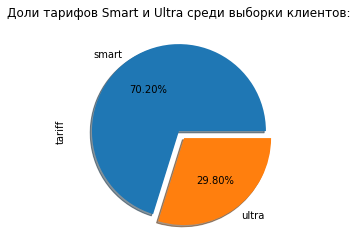

In [ ]:
#Диаграмма на основе данных списка клиентов:
users['tariff'].value_counts().plot(kind = 'pie', autopct='%1.2f%%', explode = (0, 0.1), shadow = True)
plt.title('Доли тарифов Smart и Ultra среди выборки клиентов:')
plt.show()

70% клиентов "Мегалайна" предпочитают универсальный и недорогой тариф Smart. 

Проверим, как меняются доли тарифов в выборке по месяцам. Возможно, не всегда соотношение было таким. <a id="part_month"></a>

In [ ]:
#Группируем таблицу по месяцу и тарифу. Данные - количество пользователей.
grouped_data = data.groupby(['month', 'tariff'])['user_id'].count().reset_index().sort_values(by = ['month','user_id'])
grouped_data.columns = ['month', 'tariff', 'count_users_part']
#Групппируем таблицу только по месяцу без разбивки по тарифам.
grouped_data_2 = data.groupby('month')['user_id'].count().reset_index()
grouped_data_2.columns = ['month', 'count_users_total']
#Объединяем обе таблицы по месяцу:
grouped_data = grouped_data.merge(grouped_data_2, on = 'month', how = 'left').sort_values(by = ['month','tariff'])
#Добавляем столбец с долей пользователя конкретного тарифа от общего количества пользователей:
grouped_data['%'] = grouped_data['count_users_part'] * 100/ grouped_data['count_users_total']
grouped_data.head(4)



,month,tariff,count_users_part,count_users_total,%
1,01 January,smart,34,43,79.069767
0,01 January,ultra,9,43,20.930233
3,02 February,smart,58,82,70.731707
2,02 February,ultra,24,82,29.268293


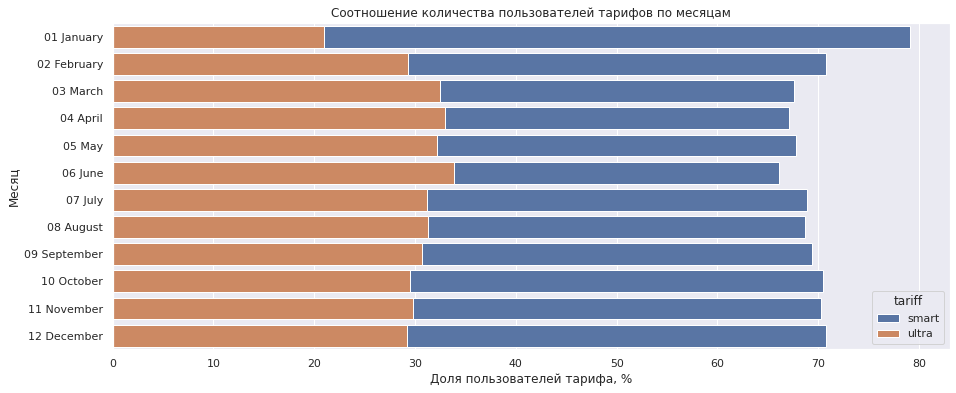

In [ ]:
#Строим столбчатую диаграмму, показывающую доли пользователей в разрезе месяца:
month = grouped_data['month']
tariff = grouped_data['tariff']
part = grouped_data['%']
sns.set()
plt.figure(figsize = (15,6))
ax = sns.barplot(y= month, x = part, hue = tariff, dodge = False)
ax.set(title = "Соотношение количества пользователей тарифов по месяцам",
      ylabel = "Месяц",
      xlabel = "Доля пользователей тарифа, %")
plt.show()

В январе доля пользователей тарифа Smart была 80%, затем в течение полугода начала снижаться примерно до 65%, затем опять приблизилась к средним 70%.

В первую очередь посмотрим на характеристики распределения данных. <a id="describe"></a>

In [ ]:
data_ultra = data.query('tariff == "ultra"')
data_smart = data.query('tariff == "smart"')
print('Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Smart":')
display(data_smart[['duration_rounded', 'mb_used_rounded', 'messages_number']].describe().loc[['mean', \
'std']].append(pd.Series(np.var(data_smart[['duration_rounded', 'mb_used_rounded', \
'messages_number']], ddof = 1), name = 'var')).style.format('{:.2f}'))

print('Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Ultra":')
display(data_ultra[['duration_rounded', 'mb_used_rounded', 'messages_number']].describe().loc[['mean', \
'std']].append(pd.Series(np.var(data_ultra[['duration_rounded', 'mb_used_rounded', \
'messages_number']], ddof = 1), name = 'var')).style.format('{:.2f}'))


Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Smart":


,duration_rounded,mb_used_rounded,messages_number
mean,429.45,16229.19,33.38
std,194.87,5877.58,28.23
var,37974.77,34545911.13,796.81


Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Ultra":


,duration_rounded,mb_used_rounded,messages_number
mean,540.78,19486.90,49.36
std,325.74,10096.32,47.80
var,106105.73,101935621.05,2285.27


По характеристикам распределения можно сделать выводы:
*   **Средняя длительность разговора не сильно зависит от тарифа**. В среднем человеку нужно около 430 минут разговора на тарифе "Smart" и 540 - на тарифе "Ultra". Среднее и медиана у распределения близки, т.е. выбросов немного.
*   **Сообщения сейчас не в моде**. Пользователи обоих тарифов за редким исключением не превышают лимит.
*   **Основные различия касаются объема интернет-трафика**. Пользователи тарифа "Smart" превышают лимит 15Гб и платят за дополнительные мегабайты чаще, чем в половине случаев. Пользователи "Ultra" используют интернет активнее (в среднем на 3Гб), но больше чем в 75% случаев не выходят за увеличенный лимит в 30Гб.



Для наглядности построим сравнительные графики длительности разговора, отправки смс и активности пользователя в сети в зависимости от выбранного тарифа. <a id="hist"></a>

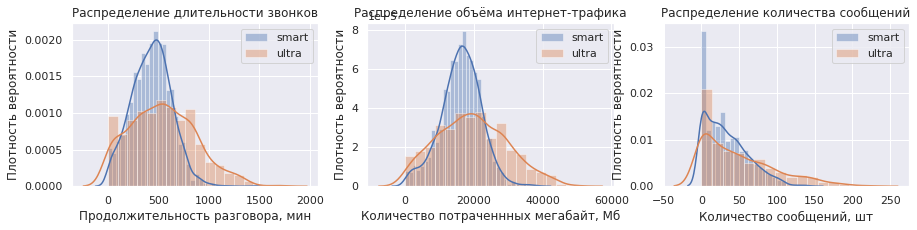

In [ ]:
#Строим гистограммы распределений ежемесячной длительности разговора, количества сообщений и объема интернет-трафика:
#tariff = data['tariff']
sns.set()
fig,axes=plt.subplots(1,3)
fig.set_size_inches(15, 3)
for tariff in ['smart', 'ultra']:
  ax = sns.distplot(data.query('tariff == @tariff')['duration_rounded'], label = tariff, ax = axes[0])
  ax1 = sns.distplot(data.query('tariff == @tariff')['mb_used_rounded'], label = tariff, ax = axes[1])
  ax2 = sns.distplot(data.query('tariff == @tariff')['messages_number'], label = tariff, ax = axes[2])

ax.set(title = "Распределение длительности звонков",
      xlabel = "Продолжительность разговора, мин",
      ylabel = "Плотность вероятности")
ax1.set(title = "Распределение объёма интернет-трафика",
      xlabel = "Количество потраченнных мегабайт, Мб",
      ylabel = "Плотность вероятности")
ax2.set(title = "Распределение количества сообщений",
      xlabel = "Количество сообщений, шт",
      ylabel = "Плотность вероятности")
      
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

В целом поведение пользователя в обоих случаях похожее, но на графиках видно **смещение вправо** распределения длительности звонков и объёма интернет-трафика **по тарифу "Ultra"**. Лимиты больше - использование свободнее.

Эти распределения близки к нормальным. **Распределение количества сообщений стремится к экспоненциальному виду**. Максимум около нуля. Пользователей, отправляющих много sms, мало.

# 6. Проверка гипотез (анализ выручки) <a id="revenue"></a>

В первую очередь посчитаем характеристики распределения выручки по тарифам. <a id="revenue_describe"></a>

In [ ]:
print('Характеристики распределения ежемесячной выручки по тарифу "Smart":')
display(data_smart[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки по тарифу "Ultra":')
display(data_ultra[['revenue_month']].describe().style.format('{:.2f}'))

Характеристики распределения ежемесячной выручки по тарифу "Smart":


,revenue_month
count,2229.00
mean,1250.33
std,797.03
min,550.00
25%,553.00
50%,986.49
75%,1701.56
max,6765.02


Характеристики распределения ежемесячной выручки по тарифу "Ultra":


,revenue_month
count,985.00
mean,2060.53
std,356.31
min,1950.00
25%,1950.00
50%,1950.00
75%,1950.00
max,4743.31


Построим гистограммы распределения выручки по тарифам.

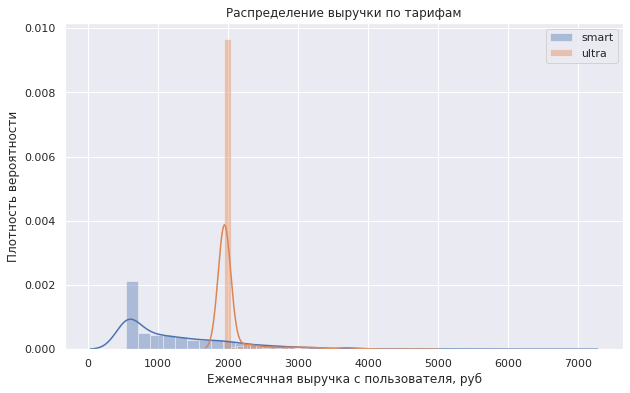

In [ ]:
sns.set()
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
for tariff in ['smart', 'ultra']:
  ax = sns.distplot(data.query('tariff == @tariff')['revenue_month'], label = tariff)
ax.set(title = "Распределение выручки по тарифам",
      xlabel = "Ежемесячная выручка с пользователя, руб",
      ylabel = "Плотность вероятности")
      
ax.legend()
plt.show()

График наглядно показывает, что выручка подчиняется экспоненциальному распределению. Пик в обоих случаях - выручка, равная абонентской плате. Меньше сумма быть не может. Количество пользователей, превышающих лимит по включенным ресурсам - больше половины на тарифе "Smart" и меньше 25% на тарифе "Ultra".

Проверим гипотезу H0 о том, что средняя выручка по тарифу "Smart" и "Ultra" в двух соответствующих генеральных совокупностях одинакова. 

Для начала проведём тест Левене о равенстве дисперсий двух выборок/совокупностей (мы предполагаем, что наши данные неоднородны и содержат выбросы, поэтому используем именно этот тест). <a id="Hyp1"></a>

In [ ]:
a = data_smart['revenue_month']
b = data_ultra['revenue_month']
alpha = 0.05
stat, p = levene(a, b)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

5.212050107656611e-119
Отвергаем нулевую гипотезу


Итак, тест Левене показал, что нужно принять альтернативную гипотезу: дисперсии совокупностей различаются. Учтем это при проведении Т-теста ниже.

In [ ]:
alpha = 0.05
results = st.ttest_ind(
    data_smart['revenue_month'], 
    data_ultra['revenue_month'],
    equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.0842599087855415e-282
Отвергаем нулевую гипотезу


Уровень значимости статистики разности средних наших показателей (**p-value**) исчезающе мал, поэтому принимаем альтернативную гипотезу: с высокой вероятностью средняя выручка по тарифам отличается, как и в нашей выборке.

In [ ]:
print('Средняя выручка с пользователя по тарифу "Smart" {:.2f} рублей.'.format(data_smart['revenue_month'].mean()))
print('Средняя выручка с пользователя по тарифу "Ultra" {:.2f} рублей.'.format(data_ultra['revenue_month'].mean()))

Средняя выручка с пользователя по тарифу "Smart" 1250.33 рублей.
Средняя выручка с пользователя по тарифу "Ultra" 2060.53 рублей.


Такой результат позволяет рекомендовать сотовому оператору провести рекламную кампанию в пользу тарифа "Ultra": увеличение его доли среди всех пользователей поднимет среднюю выручку.

Проверим еще одну гипотезу: выручка по тарифам не зависит от города проживания абонента (одинакова в Москве и регионах). <a id="hyp2"></a>

In [ ]:
#Формируем столбец с разбивкой Москва/регионы:
data['moscow_regions'] = (data['city'] == 'Москва')
data.loc[data['moscow_regions'] == True, 'moscow_regions'] = 'Москва'
data.loc[data['moscow_regions'] == False, 'moscow_regions'] = 'Регионы'
data['moscow_regions'].unique()

array(['Регионы', 'Москва'], dtype=object)

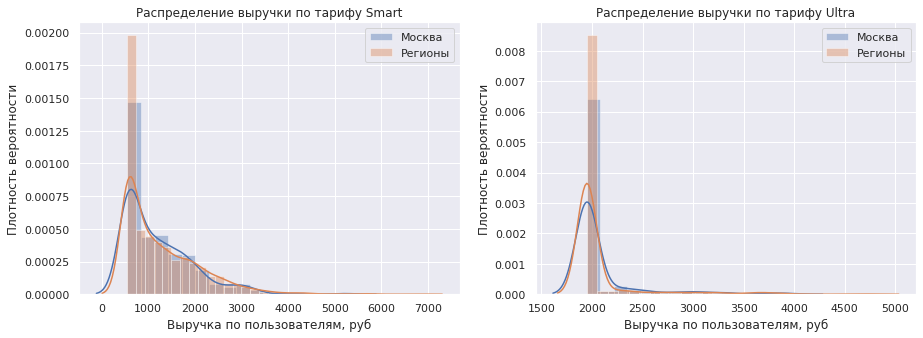

In [ ]:
#Строим гистограмму распределения выручки по заданному критерию:
#Примечание: в тренажере, видимо, не установлен последний seaborn, нужный график не отображается. Выведу другой.
#sns.displot(data=data.sort_values(by = 'tariff'),
#            x='revenue_month',
#            hue='tariff',
#            col='moscow_regions',
#            bins=30,
#            kde=True)
#plt.show()

sns.set()
fig,axes=plt.subplots(1,2)
fig.set_size_inches(15, 5)
for regions in ['Москва', 'Регионы']:
  ax = sns.distplot(data.query('tariff == "smart" and moscow_regions == @regions')['revenue_month'], label = regions, ax = axes[0])
  ax1 = sns.distplot(data.query('tariff == "ultra"and moscow_regions == @regions')['revenue_month'], label = regions, ax = axes[1])

ax.set(title = "Распределение выручки по тарифу Smart",
      xlabel = "Выручка по пользователям, руб",
      ylabel = "Плотность вероятности")
ax1.set(title = "Распределение выручки по тарифу Ultra",
      xlabel = "Выручка по пользователям, руб",
      ylabel = "Плотность вероятности")
      
ax.legend()
ax1.legend()
plt.show()

In [ ]:
data_smart_moscow = data.query('tariff == "smart" and moscow_regions == "Москва"')
data_smart_regions = data.query('tariff == "smart" and moscow_regions == "Регионы"')
print('Характеристики распределения ежемесячной выручки по тарифу "Smart" в Москве:')
display(data_smart_moscow[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки по тарифу "Smart" в регионах:')
display(data_smart_regions[['revenue_month']].describe().style.format('{:.2f}'))

data_ultra_moscow = data.query('tariff == "ultra" and moscow_regions == "Москва"')
data_ultra_regions = data.query('tariff == "ultra" and moscow_regions == "Регионы"')
print('Характеристики распределения ежемесячной выручки по тарифу "Ultra" в Москве:')
display(data_ultra_moscow[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки по тарифу "Ultra" в регионах:')
display(data_ultra_regions[['revenue_month']].describe().style.format('{:.2f}'))

Характеристики распределения ежемесячной выручки по тарифу "Smart" в Москве:


,revenue_month
count,386.00
mean,1198.43
std,727.73
min,550.00
25%,550.00
50%,979.55
75%,1624.09
max,5222.43


Характеристики распределения ежемесячной выручки по тарифу "Smart" в регионах:


,revenue_month
count,1843.00
mean,1261.19
std,810.56
min,550.00
25%,556.42
50%,988.16
75%,1723.54
max,6765.02


Характеристики распределения ежемесячной выручки по тарифу "Ultra" в Москве:


,revenue_month
count,225.00
mean,2063.63
std,330.57
min,1950.00
25%,1950.00
50%,1950.00
75%,1950.00
max,3945.26


Характеристики распределения ежемесячной выручки по тарифу "Ultra" в регионах:


,revenue_month
count,760.00
mean,2059.61
std,363.78
min,1950.00
25%,1950.00
50%,1950.00
75%,1950.00
max,4743.31


По графикам и характеристикам распределения выручки по Москве и регионам можно увидеть:


*   **Характер распределения выручки** по обоим тарифам в Москве и за её пределами **одинаков**;
*   **Средняя выручка в регионах чуть выше**, чем аналогичный показатель по Москве.


Проведем тест, чтобы отвергнуть/подтвердить нулевую гипотезу отдельно по каждому тарифу.


Рассчитываем критерий Левене о равенстве дисперсий выручки по тарифу Smart в Москве/регионах. 

In [ ]:
m_s = data_smart_moscow['revenue_month']
r_s = data_smart_regions['revenue_month']

stat, p = levene(m_s, r_s)

print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.11623734361911198
Не получилось отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу о равенстве дисперсий выручки, отразим это в параметре equal_var ниже при проведении Т-теста.

In [ ]:
#Проверяем гипотезу о равенстве выручки по тарифу Smart:
alpha = 0.05
results = st.ttest_ind(
    data_smart_moscow['revenue_month'], 
    data_smart_regions['revenue_month'],
    equal_var = True)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15952707795729637
Не получилось отвергнуть нулевую гипотезу


Вероятность ошибки при отклонении нулевой гипотезы около 16%. При такой вероятности отвергнуть её не получится. Будем считать, что **выручка по тарифу "Smart" в Москве и регионах варьирует незначительно**. 

Теперь проверим такую же гипотезу по тарифу "Ultra".
Проводим тест Левене на равенство дисперсий совокупности, чтобы сделать более точным Т-тест.

In [ ]:
m_u = data_ultra_moscow['revenue_month']
r_u = data_ultra_regions['revenue_month']

stat, p = levene(m_u, r_u)

print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.88206811444585
Не получилось отвергнуть нулевую гипотезу


Принимаем гипотезу: дисперсии выборок, как и совокупностей, равны. Отразим это в параметре equal_var при расчете ниже.

In [ ]:
#Проверяем гипотезу о равенстве выручки по тарифу Ultra:
alpha = 0.05
results = st.ttest_ind(
    data_ultra_moscow['revenue_month'], 
    data_ultra_regions['revenue_month'],
    equal_var = True)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8820681144458327
Не получилось отвергнуть нулевую гипотезу


Вероятность ошибки при отклонении этой гипотезы - болльше 88%. То есть с высокой долей вероятности мы можем утверждать, что **по тарифу "Ultra" выручка будет одинаковой по всей стране** и будет примерно равна абонентской плате. Это подтверждает наша выборка - большинство абонентов укладывается в ежемесячные лимиты, установленные оператором.

Третьим этапом сравним выручку сотового оператора по локации абонентов без разбивки по тарифам.
Нулевая гипотеза - выручка одинакова вне зависимости от региона.

Считаем характеристики распределения выручки по Москве и регионам.

In [ ]:
data_moscow = data.query('moscow_regions == "Москва"')
data_regions = data.query('moscow_regions == "Регионы"')
print('Характеристики распределения ежемесячной выручки оператора в Москве:')
display(data_moscow[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки оператора в регионах:')
display(data_regions[['revenue_month']].describe().style.format('{:.2f}'))


Характеристики распределения ежемесячной выручки оператора в Москве:


,revenue_month
count,611.00
mean,1517.04
std,740.82
min,550.00
25%,766.00
50%,1730.27
75%,1950.00
max,5222.43


Характеристики распределения ежемесячной выручки оператора в регионах:


,revenue_month
count,2603.00
mean,1494.31
std,797.21
min,550.00
25%,704.50
50%,1544.34
75%,1950.00
max,6765.02


Как и выше, проводим тест Левене на равенство дисперсий совокупности, чтобы сделать более точным Т-тест.

In [ ]:
m = data_moscow['revenue_month']
r = data_regions['revenue_month']
alpha = 0.05
stat, p = levene(m,r)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.017085270612544515
Отвергаем нулевую гипотезу


Дисперсии выборок, как и совокупностей, не равны. Отразим это в параметре equal_var при расчете ниже.

In [ ]:
#Проверяем гипотезу о равенстве выручки в целом по Москве/регионам:
alpha = 0.05
results = st.ttest_ind(
    data_moscow['revenue_month'], 
    data_regions['revenue_month'],
    equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5014487809585113
Не получилось отвергнуть нулевую гипотезу


Таким образом, вероятность ошибки при отклонении нулевой гипотезы около 50%. Или ошибёмся, или нет :). Принимаем, что выручка оператора не зависит от места проживания абонента. 

# 7. Выводы <a id="end"></a>

Проведя статистический анализ выборки из 500 абонентов сотового оператора, можем сделать следующие выводы:


*   Основные различия между пользовательским поведением - **значительное увеличение потребления интернет-трафика на тарифе "Ultra"**. Длительность звонков и отправка сообщений значительно не различаются. 
*   **Пользователи тарифа "Smart" в половине случаев не укладываются в лимиты звонков и трафика**, но даже с учетом оплаты сверх лимита тратят в среднем меньше суммы абонентской платы тарифа "Ultra".
*   **Тариф "Ultra" более выгоден для мобильного оператора**. Меньше 25% пользователей превышают лимиты, но средняя выручка выше за счет высокой абонентской платы. 
*   Возможно, маркетологам стоит поработать с характеристиками тарифа "Ultra", чтобы сделать его более привлекательным для потенциальных абонентов. 
*   В Москве доля клиентов с тарифом "Ultra" - 37%, в регионах - 29%. При этом **абоненты тарифа "Smart" из регионов в среднем приносят чуть больше выручки**, т.е. более интенсивно используют мобильную связь. На это тоже следует обратить внимание маркетологам при выборе таргет-группы для рекламы.
*   За счёт того, что в Москве доля тарифа "Ultra" выше, чем в регионах, средняя выручка по этому городу чуть выше. Однако незначительно, что и показал тест на равенство суммарной выручки. Это еще один плюс в пользу предположения, что **в регионах больше потенциал для привлечения новых "Ultra"-клиентов**.

 